In [1]:
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set()
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"axes.facecolor": ".995",
                            'axes.spines.left': False,
                            'axes.spines.top': False,
                            'axes.spines.right': False,
                            'axes.edgecolor': '.5',
                            'axes.grid': True,
                            'grid.color': '.85'})
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.marker"] = "."

# Dejanski podatki

Vir 1: NIJZ *\[[Spremljanje koronavirusa SARS-CoV-2 (COVID-19)](https://www.nijz.si/sl/pojav-novega-koronavirusa-2019-ncov)\]*  
Vir 2: NIJZ *\[[Dnevno spremljanje okužb s SARS-CoV-2 (COVID-19) [graf]](https://www.nijz.si/sl/dnevno-spremljanje-okuzb-s-sars-cov-2-covid-19)\]*

Dan 1 je *4.3.*, zadnji podatek za *19.3.*  
Podatki veljajo za konec posameznega dne, le za zadnji dan vzet podatek za naslednji dan zjutraj.

In [4]:
'''
#vir1
dni = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
okuzeni = np.array([1, 4.5, 8, 12, 16, 23, 31, 57, 89, 141, 181, 219, 253, 275, 286, 319, 341])
'''
#vir2
okuzeni = np.array([1, 6, 9, 13, 19, 29, 47, 77, 127, 174, 215, 247, 272, 283, 317, 341])
dni = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

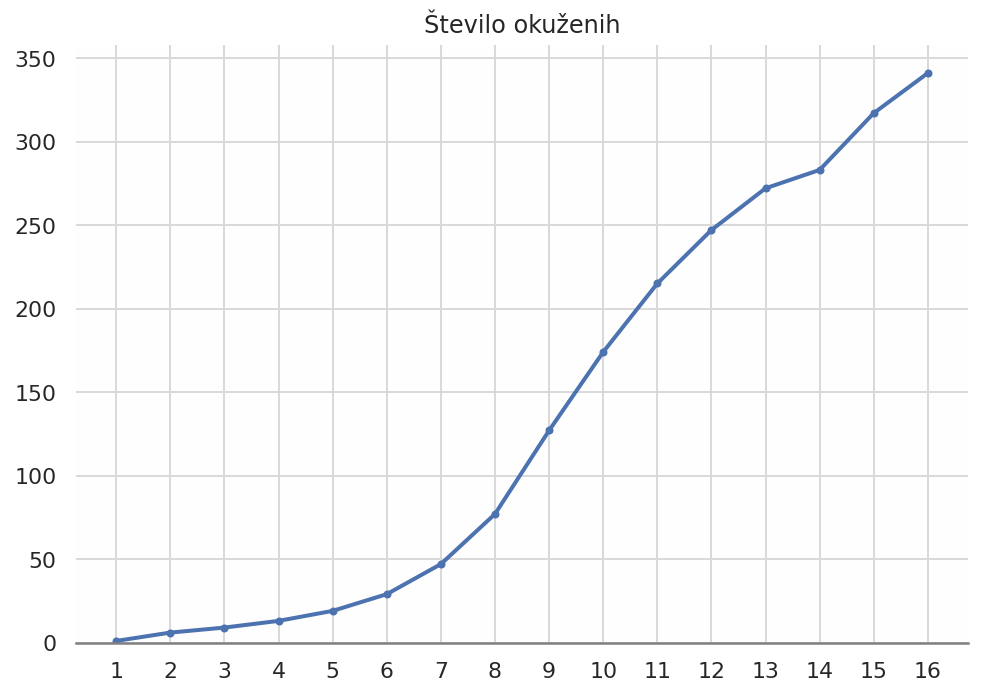

In [5]:
plt.figure(figsize=(8,5.5))
plt.xticks(dni)
plt.plot(dni, okuzeni)

plt.title("Število okuženih")
plt.ylim(0)
plt.show()

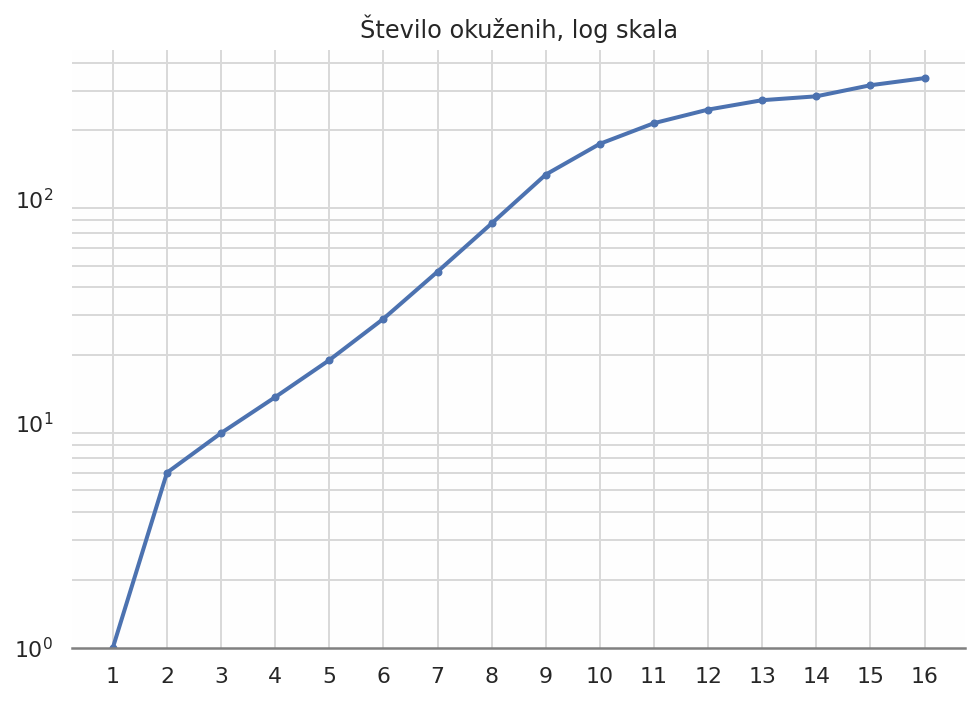

In [6]:
plt.figure(figsize=(8,5.5))
plt.xticks(dni)
plt.plot(dni, okuzeni)

plt.title("Število okuženih, log skala")
plt.yscale("log")
plt.grid(axis="y", which="both")
plt.ylim(1)
plt.show()

---

%%latex
\newpage

# Eksponentna funkcija

$$ f(x) = a^{x - b} $$

In [7]:
def eksp(x, a, b):
    return a**(x-b)

In [8]:
apr, pcov = scipy.optimize.curve_fit(eksp, dni, okuzeni)

Najdeni paremetri funkcije:

In [9]:
a, b = apr
print("a = %.2f" % a)
print("b = %.2f" % b)
print("")
print("f(x) = %.2f ^ (x - (%.2f))" % (a, b))

a = 1.19
b = -18.21

f(x) = 1.19 ^ (x - (-18.21))


## Ujemanje najdene funkcije s podatki

In [10]:
preds = eksp(dni, a, b)

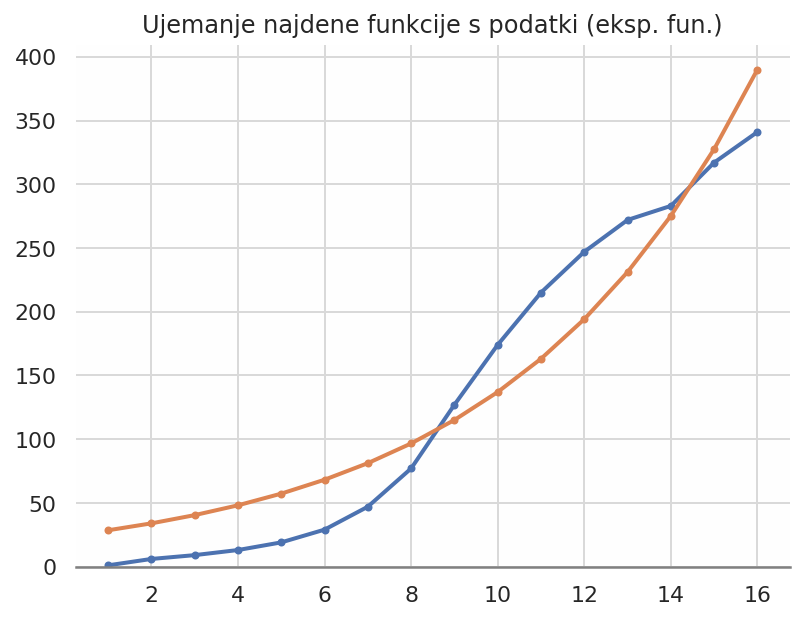

In [11]:
plt.plot(dni, okuzeni)
plt.plot(dni, preds)

plt.title("Ujemanje najdene funkcije s podatki (eksp. fun.)")
plt.ylim(0)
plt.show()

## Napoved za naprej

**Čas podovijitve** števila okuženih:

In [12]:
dbl1 = math.log(2)/math.log(a)
print("Št. okuženih se podvoji na %.1f dni." % dbl1)

Št. okuženih se podvoji na 4.0 dni.


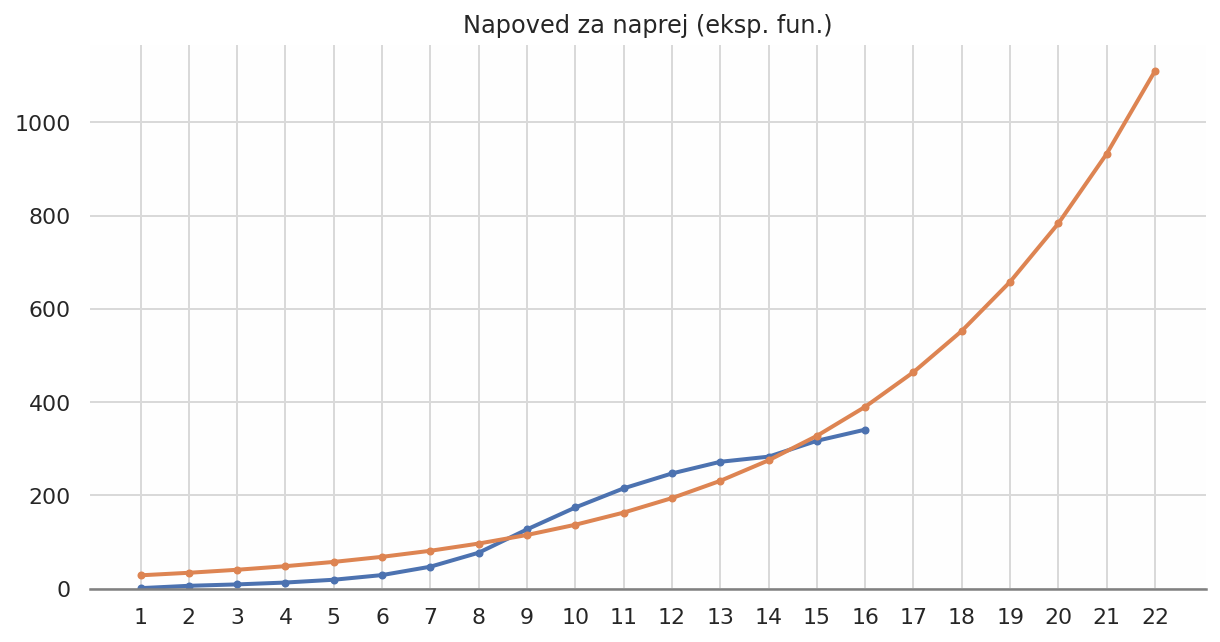

In [13]:
dni2 = np.array([i for i in range(1, 22+1)])
preds2 = eksp(dni2, a, b)

plt.figure(figsize=(10,5))
plt.xticks(dni2)

plt.plot(dni, okuzeni)
plt.plot(dni2, preds2)

plt.title("Napoved za naprej (eksp. fun.)")
plt.ylim(0)
plt.show()

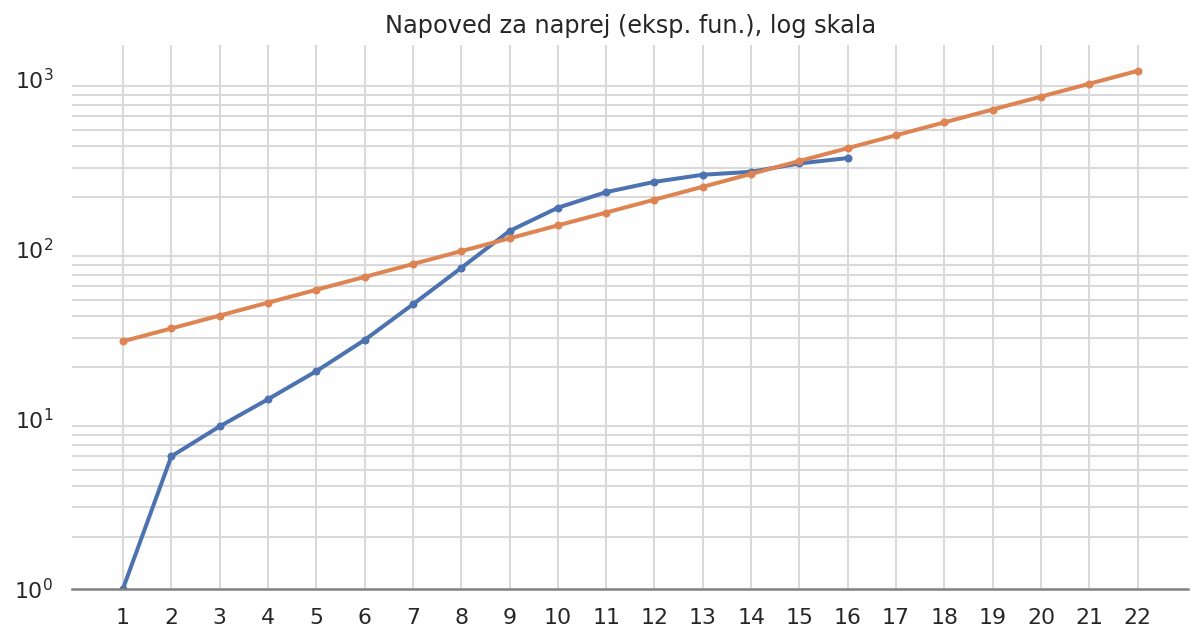

In [14]:
plt.figure(figsize=(10,5))
plt.xticks(dni2)

plt.plot(dni, okuzeni)
plt.plot(dni2, preds2)

plt.title("Napoved za naprej (eksp. fun.), log skala")
plt.yscale("log")
plt.grid(axis="y", which="both")
plt.ylim(1)
plt.show()

%%latex
\newpage

# Linearna funkcija na logaritmiranih podatkih

In [15]:
okuzeni_log = np.log(okuzeni)/np.log(10)

$$ f(x) = k * x + n $$

In [16]:
def lin(x, k, n):
    return k*x + n

In [17]:
# Prva dva dni se zaradi odstopanja ne upošteva
apr1, pcov1 = scipy.optimize.curve_fit(lin, dni[2:], okuzeni_log[2:])

Najdeni parametri linearne funkcije:

In [18]:
k, n = apr1
print("k = %.2f" % k)
print("n = %.2f" % n)
print("")
print("f(x) = %.2f*x + %.2f" % (k, n))

k = 0.13
n = 0.74

f(x) = 0.13*x + 0.74


Pretvorjeno v eksponentno funkcijo z linearno skalo:

In [19]:
a1 = np.exp(k*np.log(10))
b1 = -np.exp((n)*np.log(10))

print("a = %.2f" % a1)
print("b = %.2f" % b1)
print("")
print("f(x) = %.2f ^ (x - (%.2f))" % (a1, b1))

a = 1.34
b = -5.48

f(x) = 1.34 ^ (x - (-5.48))


## Ujemanje najdene funkcije s podatki

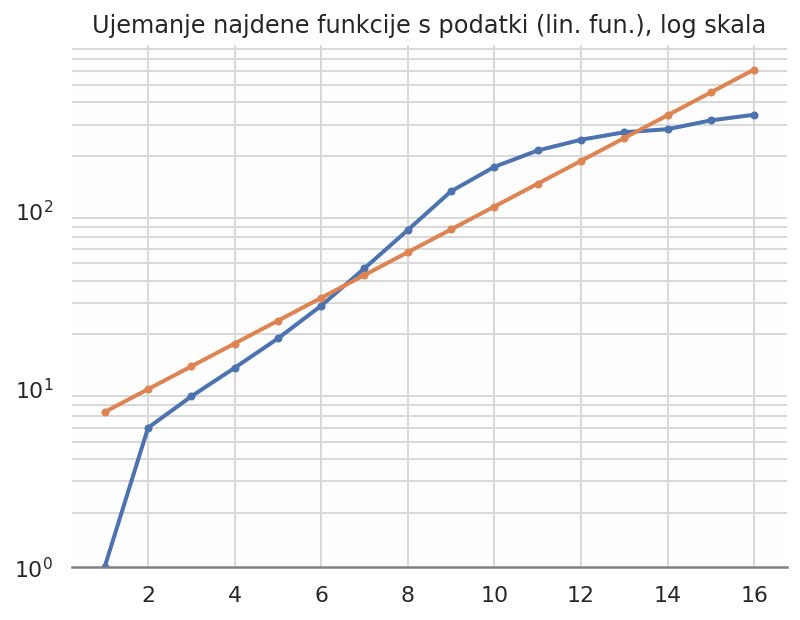

In [20]:
preds1 = lin(dni, k, n)
preds1e = np.exp(preds1*np.log(10))

plt.plot(dni, okuzeni)
plt.plot(dni, preds1e)

plt.title("Ujemanje najdene funkcije s podatki (lin. fun.), log skala")
plt.yscale("log")
plt.grid(axis="y", which="both")
plt.ylim(1)
plt.show()

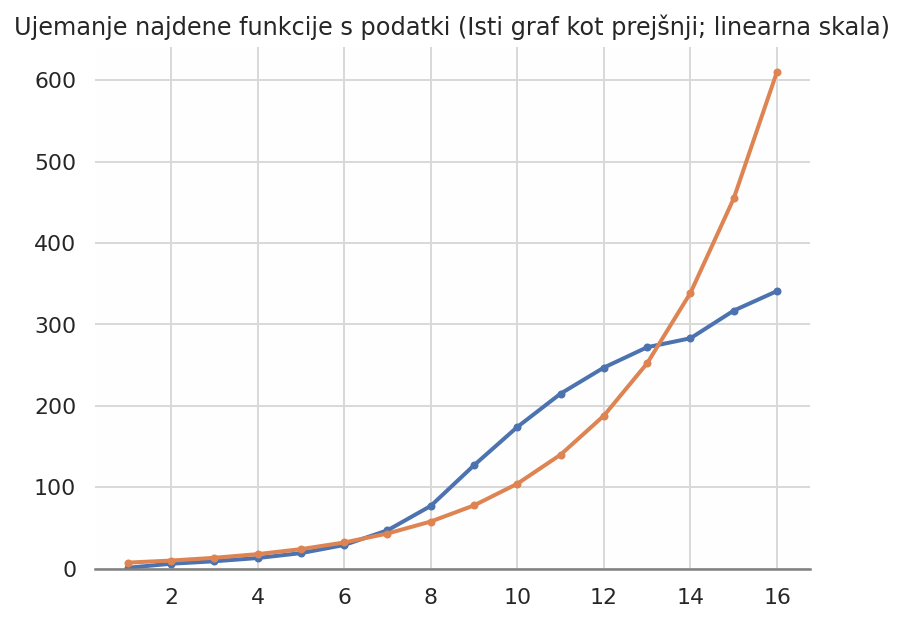

In [21]:
plt.plot(dni, okuzeni)
plt.plot(dni, preds1e)

plt.title("Ujemanje najdene funkcije s podatki (Isti graf kot prejšnji; linearna skala)")
plt.ylim(0)
plt.show()

## Napoved za naprej

**Čas podovijitve** števila okuženih:

In [22]:
dbl2 = math.log(2)/math.log(a1)
print("Št. okuženih se podvoji na %.1f dni." % dbl2)

Št. okuženih se podvoji na 2.4 dni.


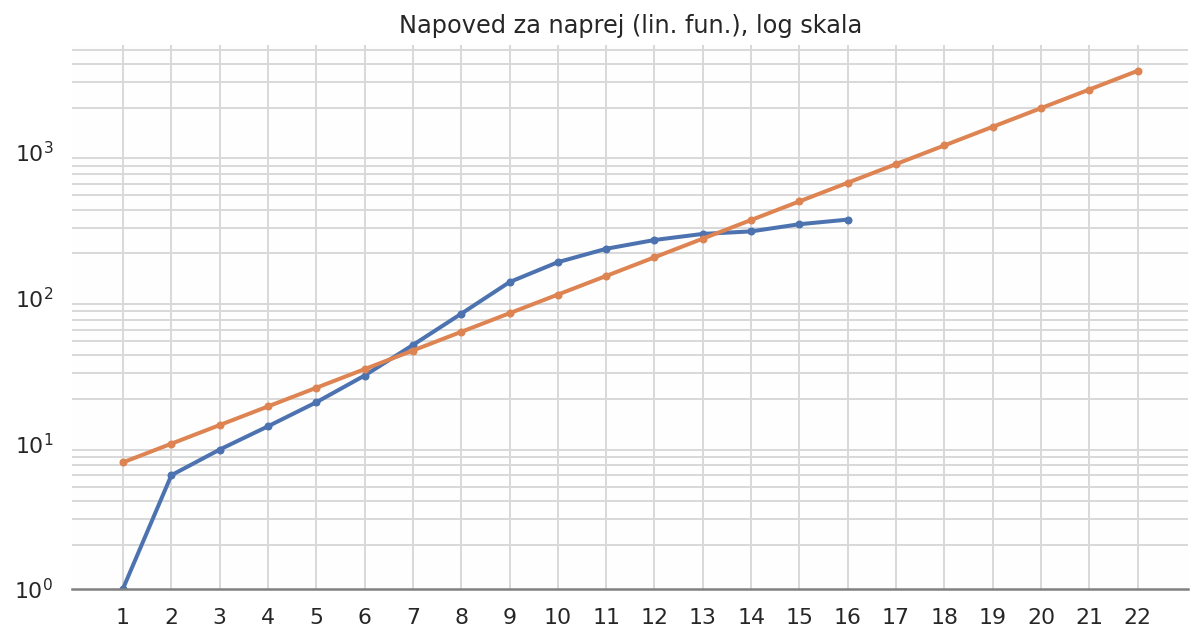

In [23]:
preds12 = lin(dni2, k, n)
preds12e = np.exp(preds12*np.log(10))

plt.figure(figsize=(10,5))
plt.xticks(dni2)

plt.plot(dni, okuzeni)
plt.plot(dni2, preds12e)

plt.title("Napoved za naprej (lin. fun.), log skala")
plt.yscale("log")
plt.grid(axis="y", which="both")
plt.ylim(1)
plt.show()

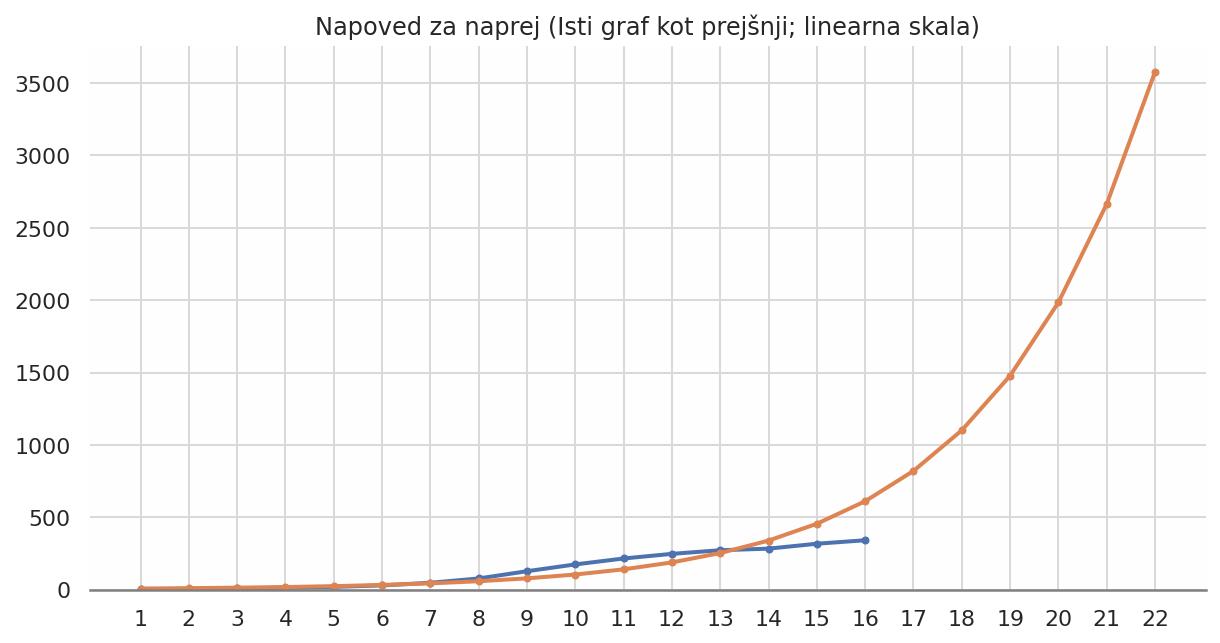

In [24]:
preds12e = np.exp(lin(dni2, k, n)*np.log(10))
plt.figure(figsize=(10,5))
plt.xticks(dni2)

plt.plot(dni, okuzeni)
plt.plot(dni2, preds12e)

plt.title("Napoved za naprej (Isti graf kot prejšnji; linearna skala)")
plt.ylim(0)
plt.show()

---

%%latex
\newpage

# Pregled rasti

In [25]:
novi = np.array([okuzeni[0]] + [okuzeni[i+1] - okuzeni[i] for i in range(okuzeni.shape[0] - 1)])

### Število novo okuženih

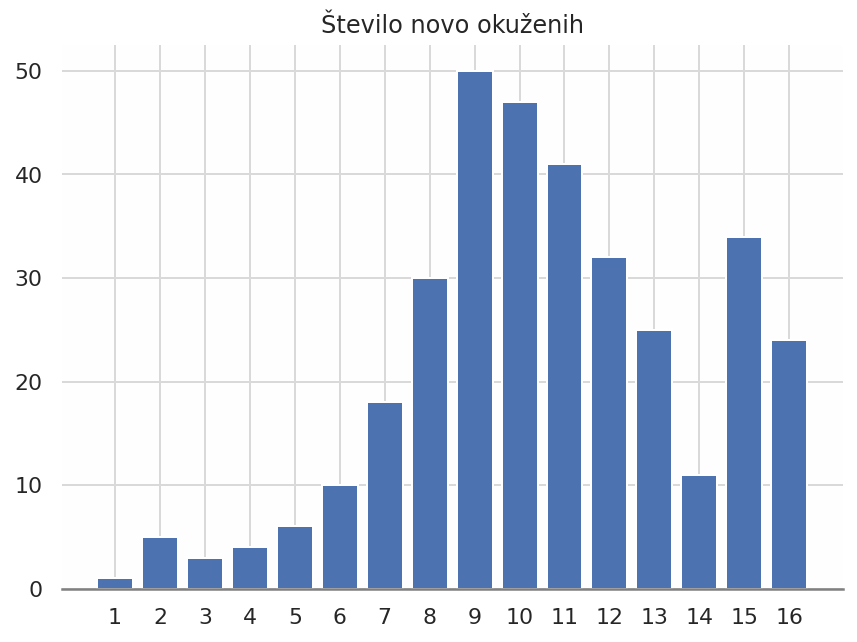

In [26]:
plt.figure(figsize=(7,5))
plt.bar(dni, novi)
plt.title("Število novo okuženih")
plt.xticks(dni)
plt.ylim(0)
plt.show()

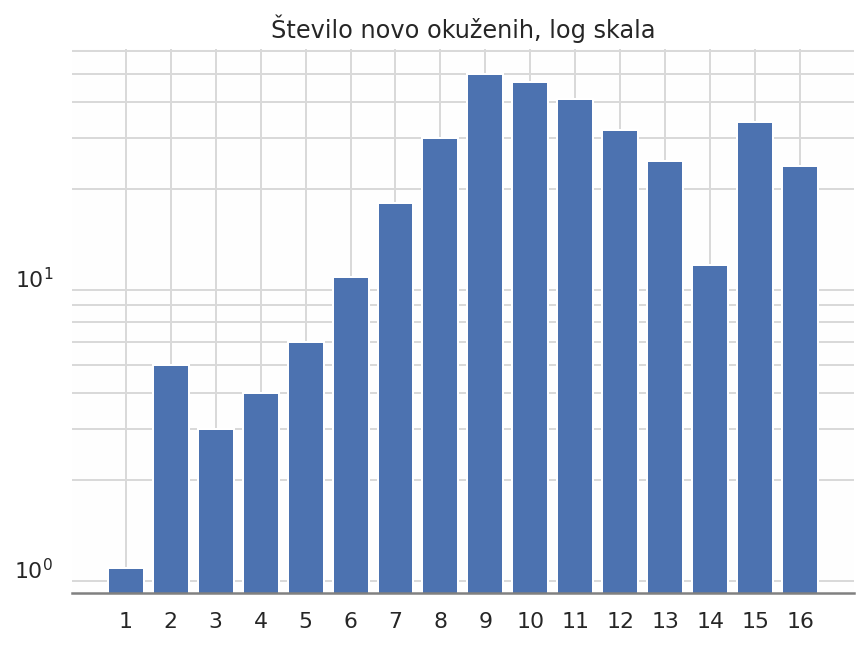

In [27]:
plt.figure(figsize=(7,5))
plt.bar(dni, novi, log=True)
plt.title("Število novo okuženih, log skala")
plt.grid(axis="y", which="both")
plt.xticks(dni)
plt.show()

### Faktor dnevne rasti

*Kolikokrat* več okuženih je nek dan glede na prejšnjega

In [28]:
rast = np.array([okuzeni[i+1]/okuzeni[i] for i in range(okuzeni.shape[0] - 1)])

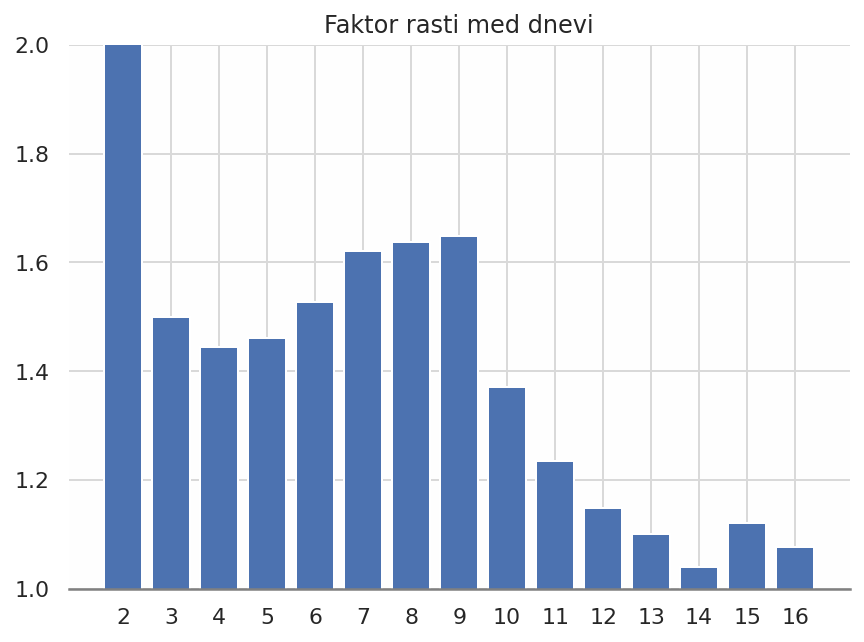

In [29]:
plt.figure(figsize=(7,5))
plt.bar(dni[1:], rast)
plt.title("Faktor rasti med dnevi")
plt.ylim(1, 2)
plt.xticks(dni[1:])
plt.show()

**Povprečni faktor dnevne rasti** zadnjih 3 dni:

In [30]:
print("%.2f" % np.average(rast[-3:]))

1.08


### Čas podvojitve števila okuženih

$$ časPodvojitve = \frac{ln(2)}{ln(faktorRasti)} $$

**Čas podvojitve** števila okuženih *glede na faktor rasti zadnjega dne* in *povprečja zadnjih dveh dni*:

In [31]:
dbl_d2 = math.log(2)/math.log(np.average(rast[-2:]))
print("Št. okuženih se bo podvojila čez %.1f dni (glede na zadnja dva dneva)" % dbl_d2)

dbl_d1 = math.log(2)/math.log(rast[-1])
print("Št. okuženih se bo podvojila čez %.1f dni (glede na zadnji dan)" % dbl_d1)

Št. okuženih se bo podvojila čez 7.4 dni (glede na zadnja dva dneva)
Št. okuženih se bo podvojila čez 9.5 dni (glede na zadnji dan)


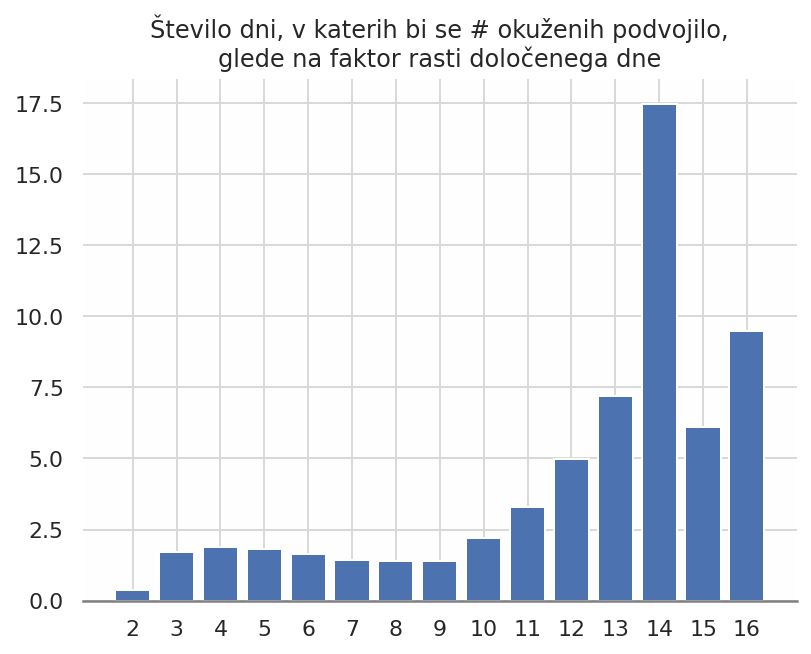

In [32]:
podvojitev = math.log(2)/np.log(rast)
plt.bar(dni[1:], podvojitev)
plt.title("Število dni, v katerih bi se # okuženih podvojilo,\nglede na faktor rasti določenega dne")
plt.xticks(dni[1:])
plt.show()

%%latex
\newpage

## Linearna funkcija novih primerov na logaritmiranih podatkih

In [33]:
novi_log = np.log(novi)/np.log(10)

In [34]:
# Prva dva dni se zaradi odstopanja ne upošteva
apr1n, pcov1n = scipy.optimize.curve_fit(lin, dni[2:], novi_log[2:])

Najdeni parametri linearne funkcije:

In [35]:
kn, nn = apr1n
print("k = %.2f" % kn)
print("n = %.2f" % nn)
print("")
print("f(x) = %.2f*x + %.2f" % (kn, nn))

k = 0.06
n = 0.64

f(x) = 0.06*x + 0.64


Pretvorjeno v eksponentno funkcijo z linearno skalo:

In [36]:
a1n = np.exp(kn*np.log(10))
b1n = -np.exp(nn*np.log(10))

print("a = %.2f" % a1n)
print("b = %.2f" % b1n)
print("")
print("f(x) = %.2f ^ (x - (%.2f))" % (a1n, b1n))

a = 1.16
b = -4.41

f(x) = 1.16 ^ (x - (-4.41))


### Ujemanje najdene funkcije s podatki

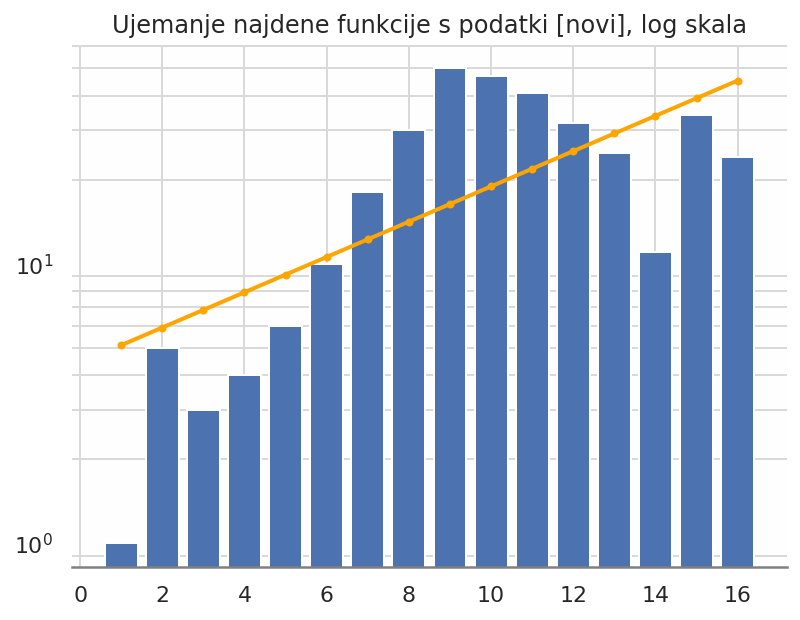

In [37]:
preds1 = lin(dni, kn, nn)
preds1e = np.exp(preds1*np.log(10))

plt.bar(dni, novi)
plt.plot(dni, preds1e, color="orange")

plt.title("Ujemanje najdene funkcije s podatki [novi], log skala")
plt.yscale("log")
plt.grid(axis="y", which="both")
plt.show()

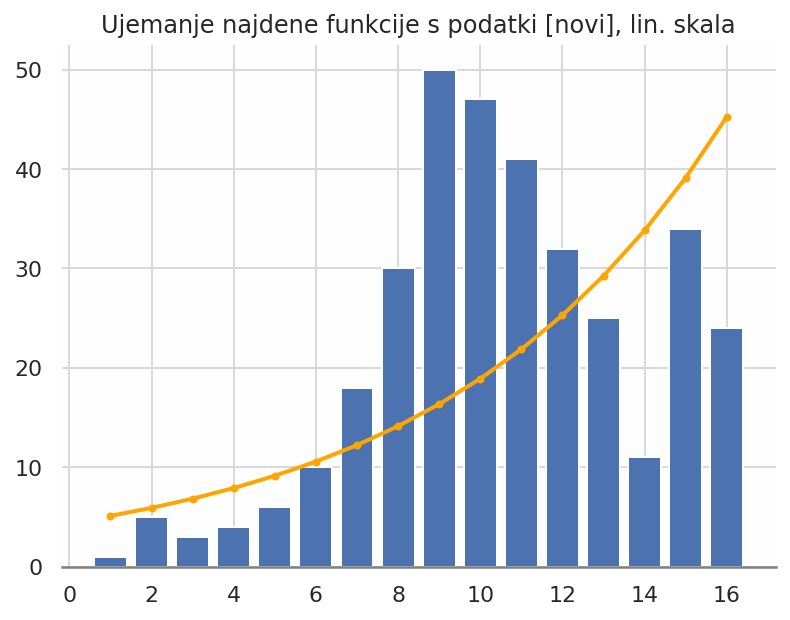

In [38]:
plt.bar(dni, novi)
plt.plot(dni, preds1e, color="orange")

plt.title("Ujemanje najdene funkcije s podatki [novi], lin. skala")
plt.ylim(0)
plt.show()

**Čas podovijitve** števila novo okuženih:

In [39]:
dbl3 = math.log(2)/math.log(a1n)
print("Št. novo okuženih se podvoji na %.1f dni." % dbl3)

Št. novo okuženih se podvoji na 4.8 dni.


---

%%latex
\newpage

# Število testiranj

In [40]:
'''
#vir1
testirani = np.array([183,208,255,290,364, 433, 785, 981, 1643, 3058, 4346, 5369, 6156, 6712, 7587, 8730, 9860, 10980])
dni_test = np.array([-3,-2,-1,0,1, 2, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17])'''
#vir2
diff = 313 # št. testiranih pred dnem 1
testirani = np.array([0,0,0,0, 51, 154, 432, 609, 847, 1214, 1756, 2505, 3550, 4747, 5663, 6253, 7111, 8232, 9400, 10667])
dni_test = np.array([-3,-2,-1,0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
testirani[4:] += diff
testirani[:4] = [183,208,255,290]

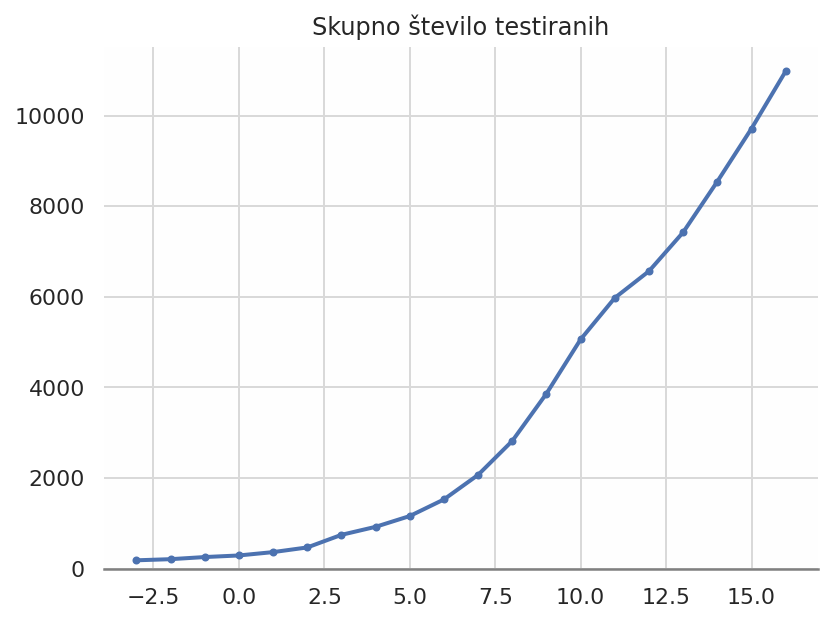

In [41]:
plt.plot(dni_test, testirani)

plt.title("Skupno število testiranih")
plt.ylim(0)
plt.show()

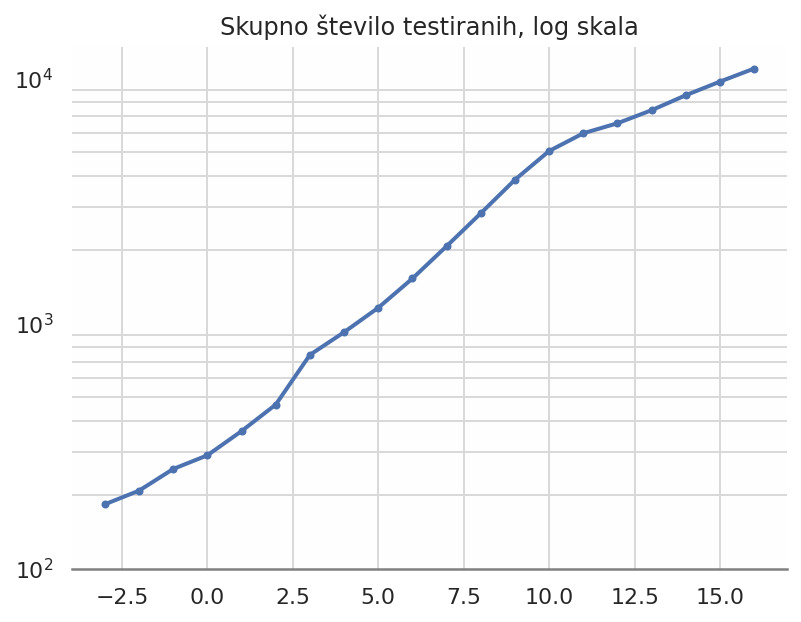

In [42]:
plt.plot(dni_test, testirani)

plt.title("Skupno število testiranih, log skala")
plt.grid(axis="y", which="both")
plt.yscale("log")
plt.ylim(100)
plt.show()

### Število novo testiranih na določen dan

Za nekatere dni ni podatka o skupnem številu testiranih. Kjer je od prejšnjega podatka minilo več kot en dan, se razliko glede na prejšnjič deli s številom preteklih dni.  
Ne upošteva se prvega dne s podatkom o št. testov ker razporeditev po dnevih pred tem ni znana.

In [43]:
novi_testi = np.array([(testirani[i+1] - testirani[i])/(dni_test[i+1] - dni_test[i]) for i in range(dni_test.shape[0] - 1)])
novi_testi2 = []

cur_i = 0
for i in range(-2, dni_test[-1]+1):
    novi_testi2.append(novi_testi[cur_i])
    if i in dni_test:
        cur_i += 1

novi_testi_full=np.array(novi_testi2)
dni_test_full = [i for i in range(-2, dni[-1] + 1)]

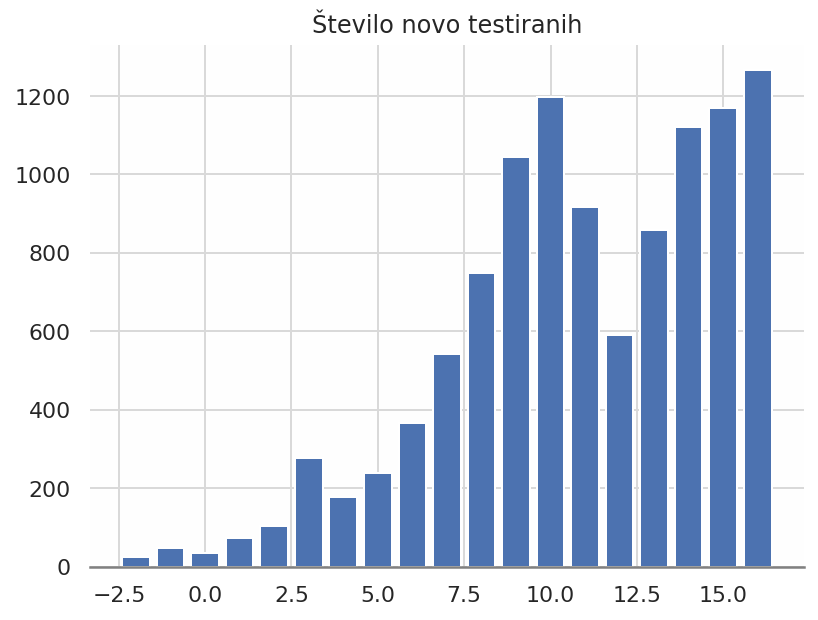

In [44]:
plt.bar(dni_test_full, novi_testi_full)

plt.title("Število novo testiranih")
plt.ylim(0)
plt.show()

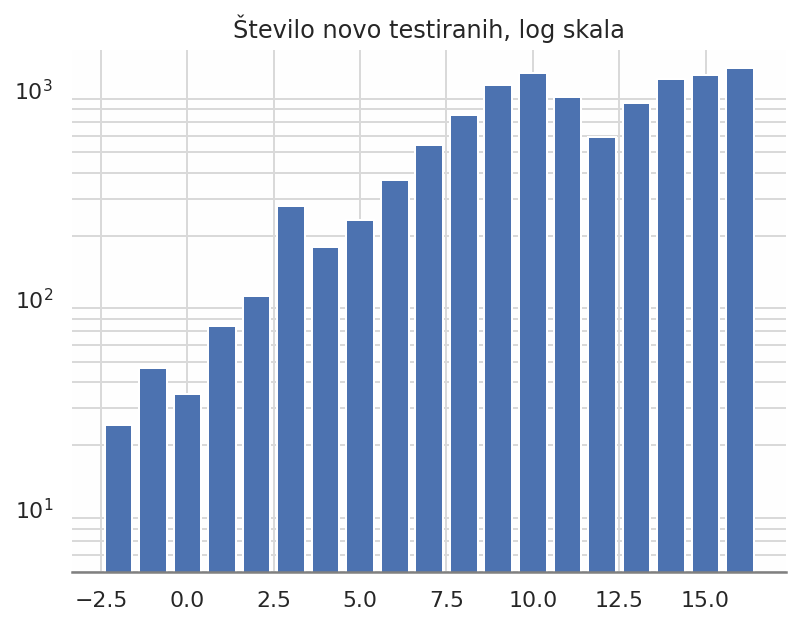

In [45]:
plt.bar(dni_test_full, novi_testi_full)

plt.title("Število novo testiranih, log skala")
plt.grid(axis="y", which="both")
plt.yscale("log")
plt.ylim(5)
plt.show()

### Odstotek pozitivnih testov

Kolikšen delež testov do vključno tistega dne je bilo pozitivnih (*št. okuženih / št. skupno testiranih*)

In [46]:
odstotek_poz = [0]
dni_odstotek = [i for i in dni_test if i >= 0]
for i, v in enumerate(dni_odstotek[1:]):
    odstotek_poz.append(okuzeni[v-1]/testirani[i+4]) # v-1, ker je prvi dan 0

odstotek_poz = np.array(odstotek_poz)
dni_odstotek = np.array(dni_odstotek)

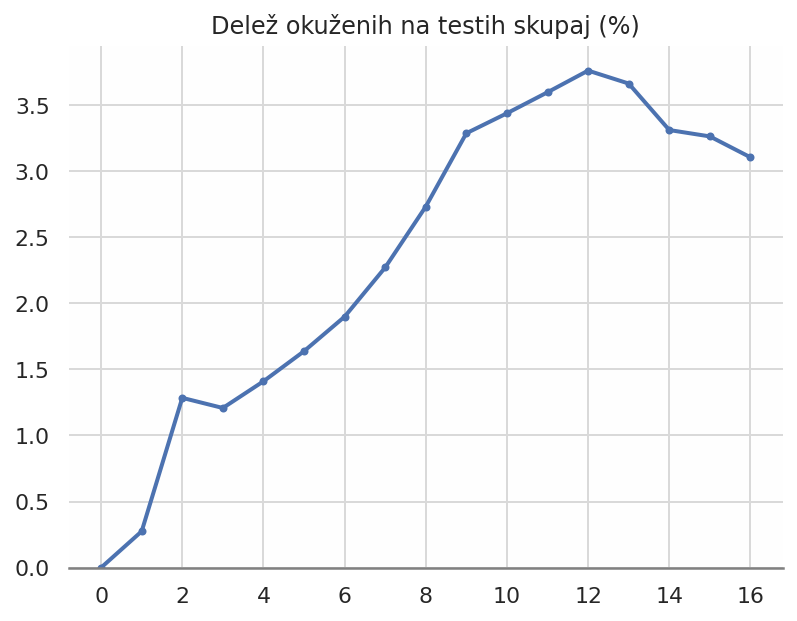

In [47]:
plt.plot(dni_odstotek, odstotek_poz*100)

plt.title("Delež okuženih na testih skupaj (%)")
plt.ylim(0)
plt.show()

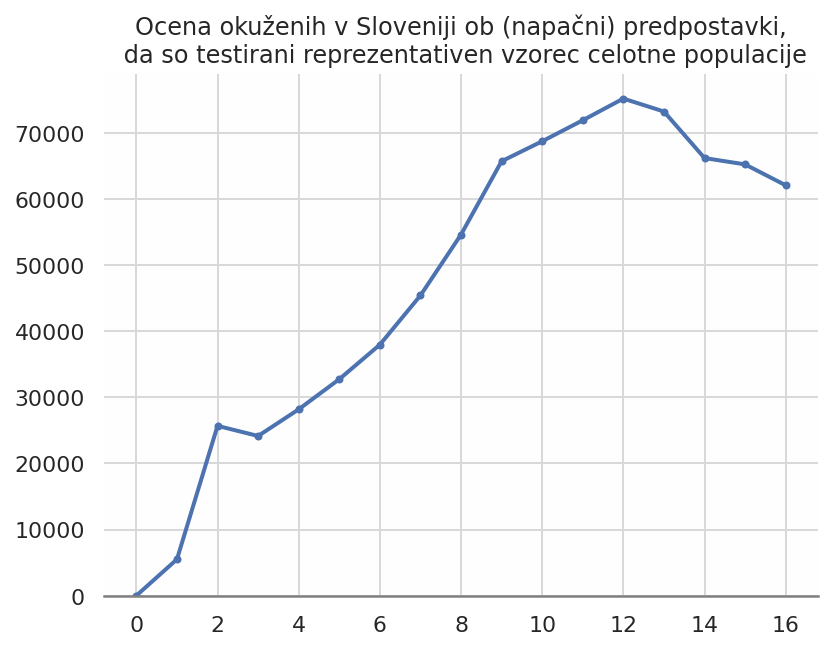

In [48]:
plt.plot(dni_odstotek, odstotek_poz*2_000_000)

plt.title("Ocena okuženih v Sloveniji ob (napačni) predpostavki,\n da so testirani reprezentativen vzorec celotne populacije")
plt.ylim(0)
plt.show()

### Odstotek pozitivnih testov na določen dan

In [49]:
odstotek_poz_novi = [0]

for i in range(dni_test.shape[0] - 1):
    testiranih_vmes = (testirani[i+1] - testirani[i])
    prvi_dan = dni_test[i]
    zadnji_dan = dni_test[i+1]
    
    prvi_okuzeni = 0 if prvi_dan <= 0 else okuzeni[prvi_dan-1]
    zadnji_okuzeni = 0 if zadnji_dan <= 0 else okuzeni[zadnji_dan-1]
    
    odstotek_poz_novi.append((zadnji_okuzeni - prvi_okuzeni) / testiranih_vmes)

od_novi = odstotek_poz_novi[4:]
temp = [0,0,0]
cur_i = 0
for i in range(1, dni_test[-1]+1):
    temp.append(od_novi[cur_i])
    if i in dni_test:
        cur_i += 1

odstotek_poz_novi = np.array(temp)

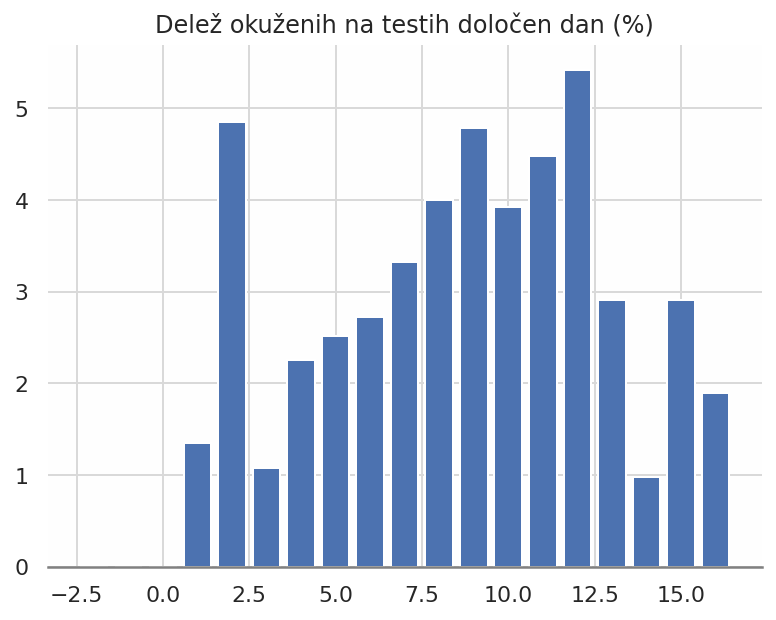

In [50]:
plt.bar(dni_test_full, odstotek_poz_novi*100)

plt.title("Delež okuženih na testih določen dan (%)")
plt.ylim(0)
plt.show()

### Število testiranj glede na število okuženih

In [51]:
temp = []
for i, v in enumerate(dni_odstotek[1:]):
    temp.append(testirani[i+4]/okuzeni[v-1]) # v-1, ker je prvi dan 0

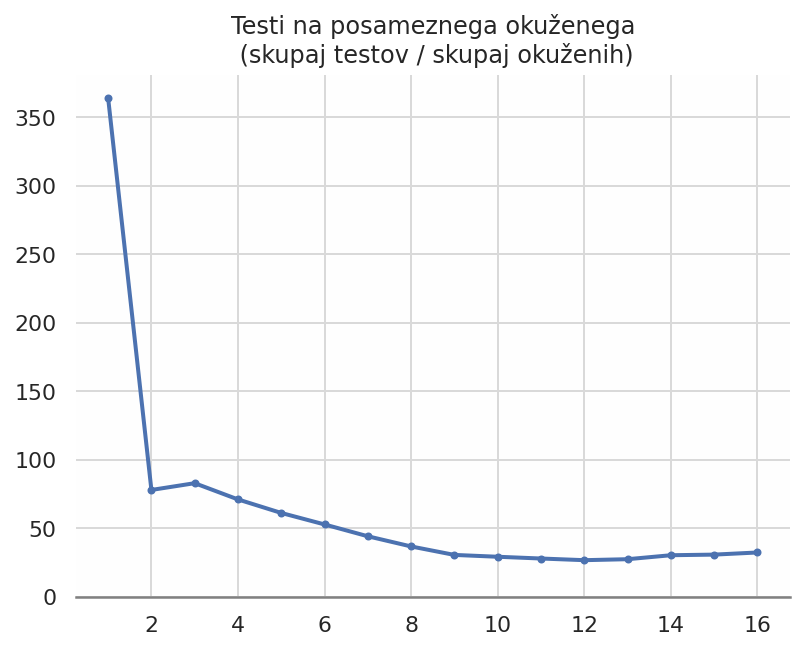

In [52]:
plt.plot(dni_odstotek[1:], temp)

plt.title("Testi na posameznega okuženega\n (skupaj testov / skupaj okuženih)")
plt.ylim(0)
plt.show()

In [53]:
testi_na_novega = [0]
novi_testi_na_novega = [0]

for i in range(dni_test.shape[0] - 1):
    testiranih_vmes = (testirani[i+1] - testirani[i])
    prvi_dan = dni_test[i]
    zadnji_dan = dni_test[i+1]
    
    prvi_okuzeni = 0 if prvi_dan <= 0 else okuzeni[prvi_dan-1]
    zadnji_okuzeni = 0 if zadnji_dan <= 0 else okuzeni[zadnji_dan-1]
    
    testi_na_novega.append(testiranih_vmes / zadnji_okuzeni)
    novi_testi_na_novega.append(testiranih_vmes / (zadnji_okuzeni - prvi_okuzeni))

od_novi = testi_na_novega[4:]
od_novi2 = novi_testi_na_novega[4:]
temp = []
temp2 = []
cur_i = 0
for i in range(1, dni_test[-1]+1):
    temp.append(od_novi[cur_i])
    temp2.append(od_novi2[cur_i])
    if i in dni_test:
        cur_i += 1

testi_na_novega = np.array(temp)
novi_testi_na_novega = np.array(temp2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in long_scalars
  del sys.path[0]


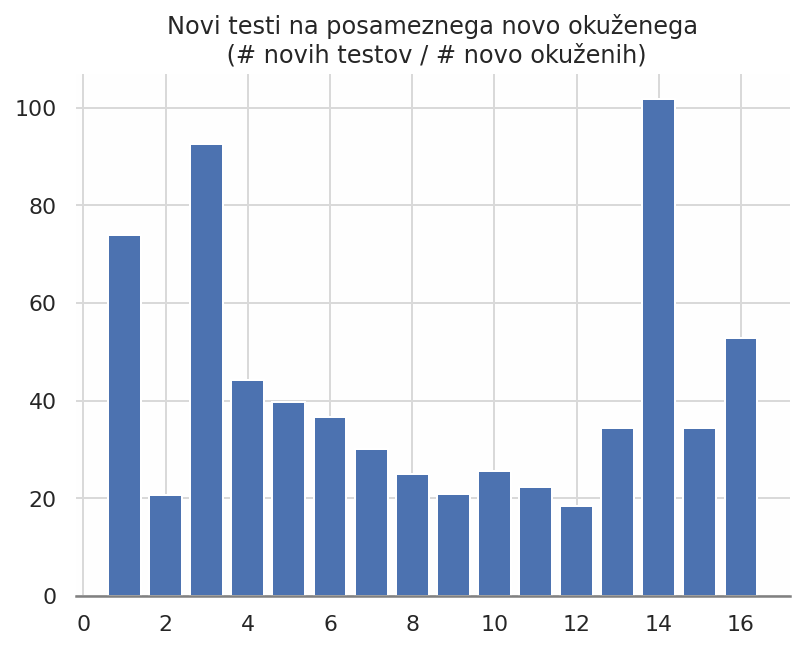

In [54]:
plt.bar(dni, novi_testi_na_novega)

plt.title("Novi testi na posameznega novo okuženega\n (# novih testov / # novo okuženih)")
plt.ylim(0)
plt.show()

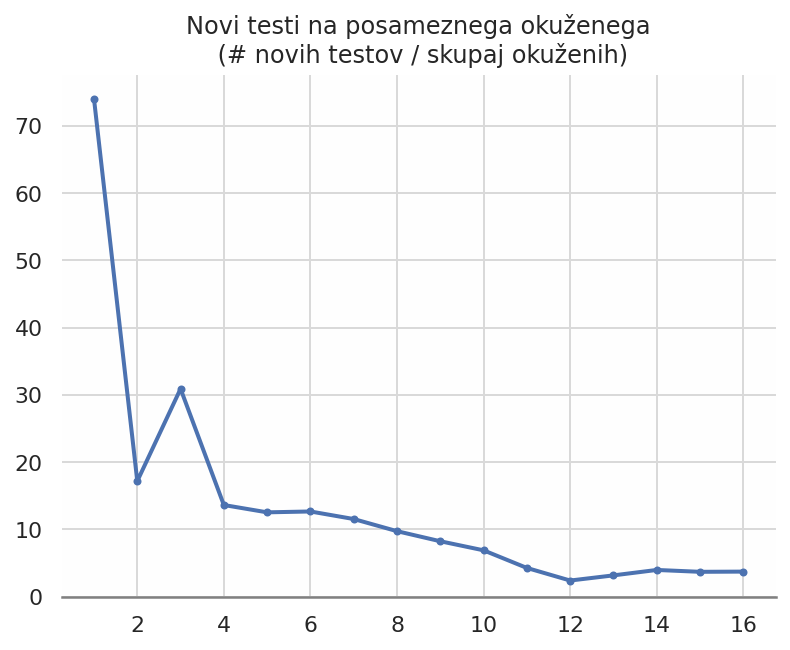

In [55]:
plt.plot(dni, testi_na_novega)

plt.title("Novi testi na posameznega okuženega\n (# novih testov / skupaj okuženih)")
plt.ylim(0)
plt.show()

---

%%latex
\newpage

# Pregled nad vsem skupaj

In [56]:
import pandas as pd

In [57]:
df = pd.DataFrame({"datum": [str(i+3) + ".3." for i in dni],
                   "okuzeni":okuzeni, "okuzeni novi":novi,
                  "testirani": testirani[4:], "testirani novi":novi_testi[3:]})

In [58]:
df

,datum,okuzeni,okuzeni novi,testirani,testirani novi
0,4.3.,1,1,364,74.0
1,5.3.,6,5,467,103.0
2,6.3.,9,3,745,278.0
3,7.3.,13,4,922,177.0
4,8.3.,19,6,1160,238.0
5,9.3.,29,10,1527,367.0
6,10.3.,47,18,2069,542.0
7,11.3.,77,30,2818,749.0
8,12.3.,127,50,3863,1045.0
9,13.3.,174,47,5060,1197.0


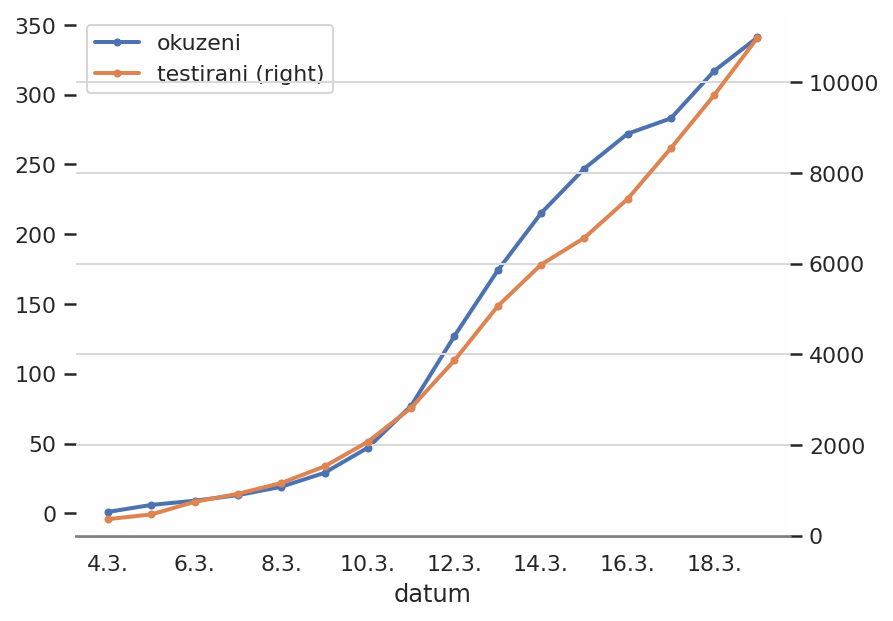

In [59]:
df[["datum", "okuzeni"]].plot("datum", legend=True)
df["testirani"].plot(legend=True, secondary_y=True)
#df["novi"].plot(legend=True)
#(df["novi"]/df["okuzeni"])[2:].plot(secondary_y=True, label="faktor rasti", legend=True)
plt.ylim(0)
plt.show()

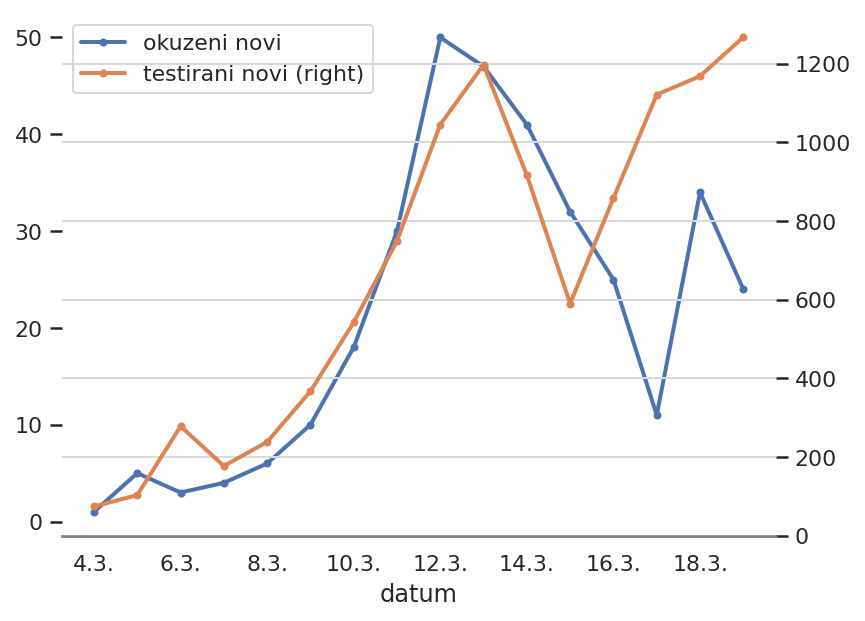

In [60]:
df[["datum", "okuzeni novi"]].plot("datum", legend=True)
df["testirani novi"].plot(legend=True, secondary_y=True)
plt.ylim(0)
plt.show()

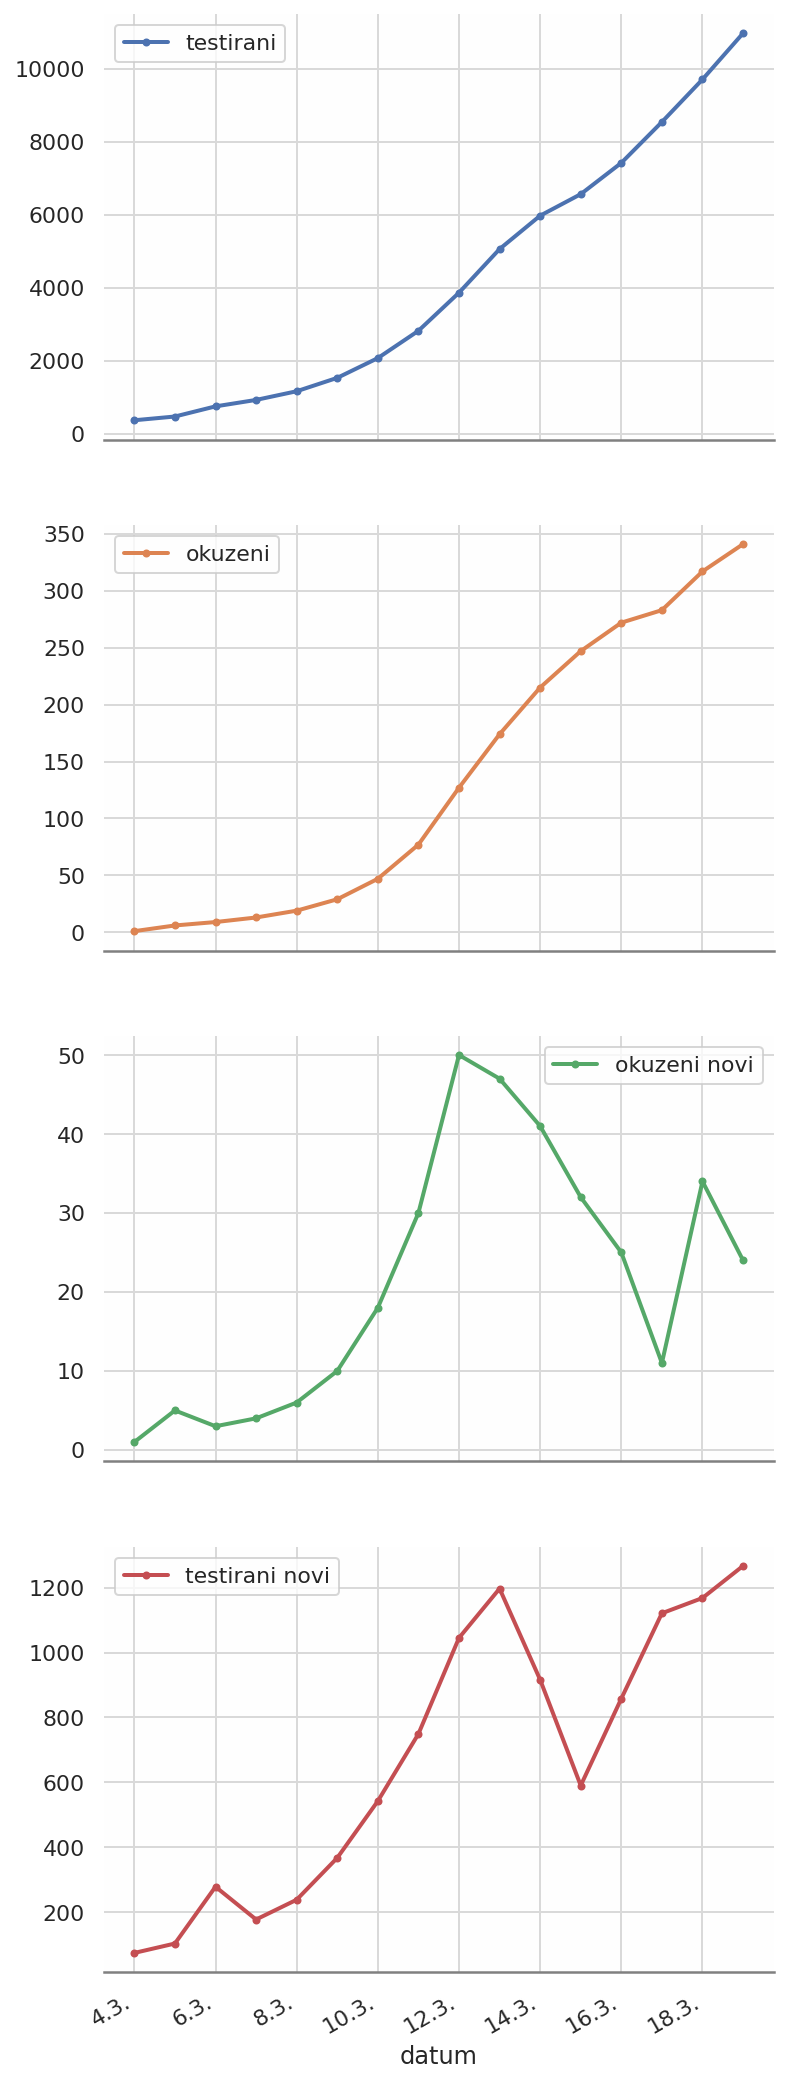

In [61]:
df[["datum", "testirani", "okuzeni", "okuzeni novi", "testirani novi"]]\
    .plot("datum", subplots=True, figsize=(6,20), grid=True, logy=False)
plt.show()

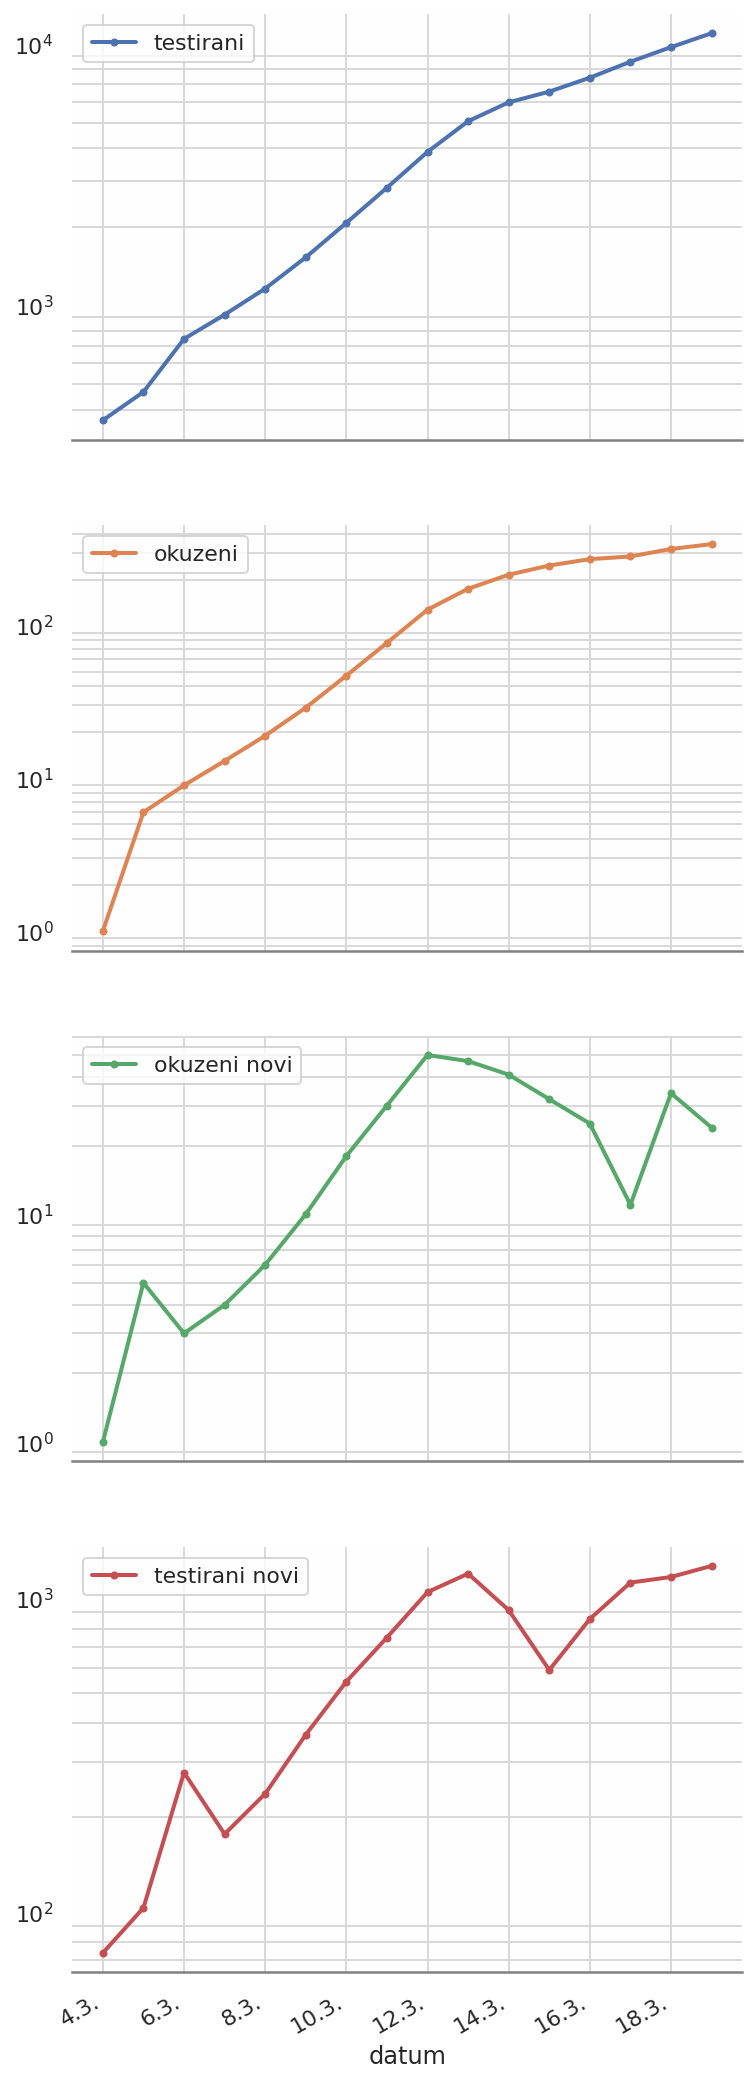

In [62]:
axs = df[["datum", "testirani", "okuzeni", "okuzeni novi", "testirani novi"]]\
        .plot("datum", subplots=True, figsize=(6,20), grid=True, logy=True)
for ax in axs:
    ax.grid(which="both", axis="y")
plt.show()

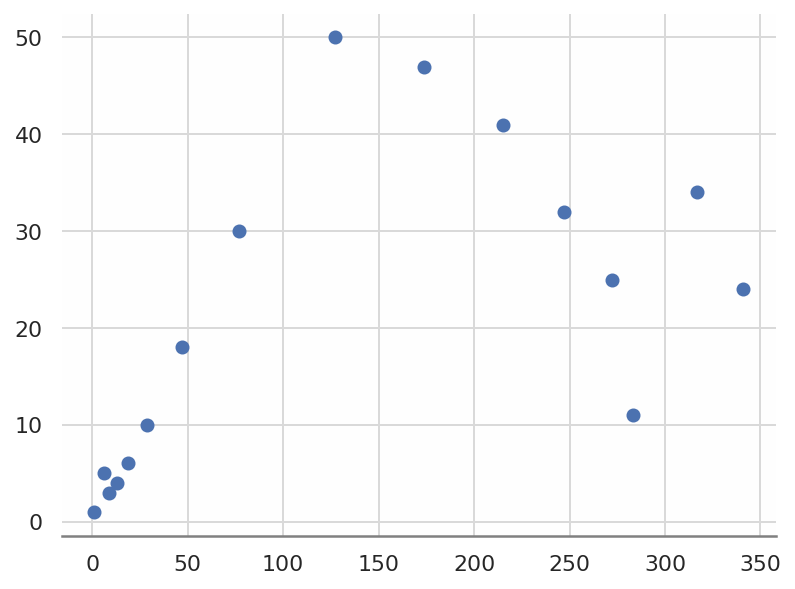

In [63]:
plt.scatter(df["okuzeni"], df["okuzeni novi"])
plt.show()